In [16]:
# Import Libraries

import pandas as pd
import matplotlib.pyplot as plt # Data Visualisation
import numpy as np
import re

# Cleaning Stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

#Preparing Machine Learning Models - Classifiers
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer

# Classification Models
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

# Evaluation Metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc

# Statistical Testing
from scipy.stats import wilcoxon

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\shrik\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [17]:
# Download & read data

# Choose the project (options: 'pytorch', 'tensorflow', 'keras', 'incubator-mxnet', 'caffe')
project = 'pytorch' # Please change this line depending on what dataset/project you would like to check the results for, the options are given above
path = f'csv_files/{project}.csv'

pd_all = pd.read_csv(path)
pd_all = pd_all.sample(frac=1, random_state=999)  # Shuffle

# Merge Title and Body into a single column; if Body is NaN, use Title only
pd_all['Title+Body'] = pd_all.apply(
    lambda row: row['Title'] + '. ' + row['Body'] if pd.notna(row['Body']) else row['Title'],
    axis=1
)

# Keep only necessary columns: id, Number, class, text (merged Title+Body)
pd_tplusb = pd_all.rename(columns={
    "Unnamed: 0": "id",
    "Title+Body": "text"
})
pd_tplusb.to_csv('Title+Body.csv', index=False, columns=["id", "Number", "class", "text"])

In [18]:
# Text preprocessing methods

def remove_html(text):
    """Remove HTML tags using a regex."""
    html = re.compile(r'<.*?>')
    return html.sub(r'', text)

def remove_emoji(text):
    """Remove emojis using a regex pattern."""
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"  # enclosed characters
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

# Stopwords
NLTK_stop_words_list = stopwords.words('english')
custom_stop_words_list = ['...']  # You can customize this list as needed
mean_stop_words_list = NLTK_stop_words_list + custom_stop_words_list

def remove_stopwords(text):
    """Remove stopwords from the text."""
    return " ".join([word for word in str(text).split() if word not in mean_stop_words_list])

def clean_str(string):
    """
    Clean text by removing non-alphanumeric characters,
    and convert it to lowercase.
    """
    string = re.sub(r"[^A-Za-z0-9(),.!?\'\`]", " ", string)
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"\)", " ) ", string)
    string = re.sub(r"\?", " ? ", string)
    string = re.sub(r"\s{2,}", " ", string)
    string = re.sub(r"\\", "", string)
    string = re.sub(r"\'", "", string)
    string = re.sub(r"\"", "", string)
    return string.strip().lower()

In [19]:
# Remove NULL values

pd_tplusb.dropna(axis = 0, how = 'any')
pd_tplusb.dropna(inplace=True)
pd_tplusb.reset_index(drop=True, inplace=True)

In [20]:
pd_tplusb.info()
pd_tplusb.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 451 entries, 0 to 450
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          451 non-null    int64 
 1   Repository  451 non-null    object
 2   Number      451 non-null    int64 
 3   State       451 non-null    object
 4   Title       451 non-null    object
 5   Body        451 non-null    object
 6   Labels      451 non-null    object
 7   Comments    451 non-null    object
 8   Codes       451 non-null    object
 9   Commands    451 non-null    object
 10  class       451 non-null    int64 
 11  related     451 non-null    int64 
 12  text        451 non-null    object
dtypes: int64(4), object(9)
memory usage: 45.9+ KB


,id,Repository,Number,State,Title,Body,Labels,Comments,Codes,Commands,class,related,text
0,616,pytorch,13787,closed,Dataloader Segmentation Fault when using MPI b...,## 🐛 Bug\r\n\r\nWhen using DistributedDataPara...,oncall: distributed,"[""Distributed Data Parallel doesn't support MP...",['\r\n[82362] *** Process received signal ***\...,['mpirun -n 4 python pytorch-examples/imagenet...,0,0,Dataloader Segmentation Fault when using MPI b...
1,322,pytorch,18998,open,torch.from_PIL() Request ?,## 🚀 Feature\r\nA simple method for transformi...,feature module: vision triaged,"[""This should really not be PIL specific, but ...",['torch.from_numpy()'],[],0,0,torch.from_PIL() Request ?. ## 🚀 Feature\r\nA ...
2,57,pytorch,23871,closed,Quantized conv is 6x slower than float on CPU,Repro:\r\n Run resnext101-32x8d with quantized...,oncall: quantization quantization_release_1.3 ...,['Pretty sure all layout issues have been addr...,[],[],1,1,Quantized conv is 6x slower than float on CPU....
3,350,pytorch,15284,open,index_add_ with scalar values instead of tensors,"Hi, I was wondering whether we could update fu...",enhancement module: advanced indexing triaged,['Seems like a reasonable ask.'],[],"['index_add_(dim, index, tensor)', 'tensor']",0,0,index_add_ with scalar values instead of tenso...
4,311,pytorch,9983,open,[feature request] Add matrix functions,Add matrix power as implemented by [numpy.lina...,function request high priority module: linear ...,['Matrix power can be easily implemented in Py...,[],[],0,0,[feature request] Add matrix functions. Add ma...


In [21]:
# Showing the removal of NULL values

pd_tplusb.isnull().sum()

id            0
Repository    0
Number        0
State         0
Title         0
Body          0
Labels        0
Comments      0
Codes         0
Commands      0
class         0
related       0
text          0
dtype: int64

In [22]:
# TF-IDF Vectorizer for the baseline and chosen model

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(pd_tplusb['text'])
X = X.toarray()
vectorizer.get_feature_names_out()
y = pd_tplusb['class']

In [23]:
# Preparing, training and testing the baseline model in order to compare with the chosen classifier to beat the baseline

datafile = 'Title+Body.csv'

repeat = 10

out_csv_name = f'../{project}_NB.csv'

nb_accuracy_scores = []
nb_precision_scores = []
nb_recall_scores = []
nb_f1_scores = []
nb_auc_values  = []

for i in range(repeat): # For loop to repeat the experiment ten times
    print(f"\nRepeat {i + 1}:")

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

    gnb = GaussianNB() # Baseline model - Naive Bayes (NB)

    y_pred = gnb.fit(X_train, y_train).predict(X_test)

    # Accuracy
    acc = accuracy_score(y_test, y_pred)
    nb_accuracy_scores.append(acc)
    print("Accuracy Score: ", acc)

    # Precision (macro)
    prec = precision_score(y_test, y_pred, average='macro')
    nb_precision_scores.append(prec)
    print("Precision Score: ",prec)

    # Recall (macro)
    rec = recall_score(y_test, y_pred, average='macro')
    nb_recall_scores.append(rec)
    print("Recall Score: ",rec)

    # F1 Score (macro)
    f1 = f1_score(y_test, y_pred, average='macro')
    nb_f1_scores.append(f1)
    print("F1 Score: ",f1)

    # AUC
    fpr, tpr, _ = roc_curve(y_test, y_pred, pos_label=1)
    auc_val = auc(fpr, tpr)
    print("AUC Value: ", auc_val)
    nb_auc_values.append(auc_val)


Repeat 1:
Accuracy Score:  0.8529411764705882
Precision Score:  0.4393939393939394
Recall Score:  0.48333333333333334
F1 Score:  0.4603174603174603
AUC Value:  0.48333333333333334

Repeat 2:
Accuracy Score:  0.8529411764705882
Precision Score:  0.4393939393939394
Recall Score:  0.48333333333333334
F1 Score:  0.4603174603174603
AUC Value:  0.48333333333333334

Repeat 3:
Accuracy Score:  0.8529411764705882
Precision Score:  0.4393939393939394
Recall Score:  0.48333333333333334
F1 Score:  0.4603174603174603
AUC Value:  0.48333333333333334

Repeat 4:
Accuracy Score:  0.8529411764705882
Precision Score:  0.4393939393939394
Recall Score:  0.48333333333333334
F1 Score:  0.4603174603174603
AUC Value:  0.48333333333333334

Repeat 5:
Accuracy Score:  0.8529411764705882
Precision Score:  0.4393939393939394
Recall Score:  0.48333333333333334
F1 Score:  0.4603174603174603
AUC Value:  0.48333333333333334

Repeat 6:
Accuracy Score:  0.8529411764705882
Precision Score:  0.4393939393939394
Recall Scor

In [24]:
# Mean/Average Values

print("Accuracy Scores: ", nb_accuracy_scores)
print("Precision Scores: ", nb_precision_scores)
print("Recall Scores: ", nb_recall_scores)
print("F1 Scores: ", nb_f1_scores)
print("AUC Values: ", nb_auc_values)

nb_mean_accuracy_score  = np.mean(nb_accuracy_scores)
nb_mean_precision_score = np.mean(nb_precision_scores)
nb_mean_recall_score = np.mean(nb_recall_scores)
nb_mean_f1_score = np.mean(nb_f1_scores)
nb_mean_auc_values = np.mean(nb_auc_values)

print("\nNaive Bayes + TF-IDF Results (Baseline)")
print(f"Number of repeats:     {repeat}")
print(f"Average Accuracy:      {nb_mean_accuracy_score:.4f}")
print(f"Average Precision:     {nb_mean_precision_score:.4f}")
print(f"Average Recall:        {nb_mean_recall_score:.4f}")
print(f"Average F1 score:      {nb_mean_f1_score:.4f}")
print(f"Average AUC:           {nb_mean_auc_values:.4f}")

Accuracy Scores:  [0.8529411764705882, 0.8529411764705882, 0.8529411764705882, 0.8529411764705882, 0.8529411764705882, 0.8529411764705882, 0.8529411764705882, 0.8529411764705882, 0.8529411764705882, 0.8529411764705882]
Precision Scores:  [np.float64(0.4393939393939394), np.float64(0.4393939393939394), np.float64(0.4393939393939394), np.float64(0.4393939393939394), np.float64(0.4393939393939394), np.float64(0.4393939393939394), np.float64(0.4393939393939394), np.float64(0.4393939393939394), np.float64(0.4393939393939394), np.float64(0.4393939393939394)]
Recall Scores:  [np.float64(0.48333333333333334), np.float64(0.48333333333333334), np.float64(0.48333333333333334), np.float64(0.48333333333333334), np.float64(0.48333333333333334), np.float64(0.48333333333333334), np.float64(0.48333333333333334), np.float64(0.48333333333333334), np.float64(0.48333333333333334), np.float64(0.48333333333333334)]
F1 Scores:  [np.float64(0.4603174603174603), np.float64(0.4603174603174603), np.float64(0.4603

In [25]:
# Saving the final results (mean results for NB + TF-IDF) to a CSV file (append mode)
try:
    # Attempt to check if the file already has a header
    existing_data = pd.read_csv(out_csv_name, nrows=1)
    header_needed = False
except:
    header_needed = True

df_log = pd.DataFrame(
    {
        'repeated_times': [repeat],
        'Accuracy': [nb_mean_accuracy_score],
        'Precision': [nb_mean_precision_score],
        'Recall': [nb_mean_recall_score],
        'F1': [nb_mean_f1_score],
        'AUC': [nb_mean_auc_values],
        'CV_list(AUC)': [str(nb_auc_values)]
    }
)

df_log.to_csv(out_csv_name, mode='a', header=header_needed, index=False)

print(f"\nResults have been saved to: {out_csv_name}")


Results have been saved to: ../pytorch_NB.csv


In [26]:
# Preparing, training and testing the chosed model (Decision Tree) in order to compare with the chosen classifier to beat the baseline

datafile = 'Title+Body.csv'

repeat = 10

out_csv_name = f'../{project}_DT.csv'

# Initialising Grid Search
param_grid = {
    'max_depth': [2, 5, 10],
    'min_samples_split': [2, 5, 10],
    'criterion': ['gini', 'entropy']
}

dt_accuracy_scores = []
dt_precision_scores = []
dt_recall_scores = []
dt_f1_scores = []
dt_auc_values  = []

for i in range(repeat):
    print(f"\nRepeat {i + 1}:")

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

    dt = DecisionTreeClassifier() # Decision Tree (DT)

    # Grid Search
    # Reference: https://medium.com/biased-algorithms/grid-search-for-decision-tree-ababbfb89833
    grid = GridSearchCV(
        dt,
        param_grid=param_grid,
        cv=5,              # 5-fold CV (can be changed)
        scoring='roc_auc'  # Using roc_auc as the metric for selection
    )
    grid.fit(X_train, y_train)

    # Retrieve the best model
    best_dt = grid.best_estimator_
    best_dt.fit(X_train, y_train)

    y_pred = best_dt.predict(X_test)
    
    # Accuracy
    acc = accuracy_score(y_test, y_pred)
    dt_accuracy_scores.append(acc)
    print("Accuracy Score: ", acc)

    # Precision (macro)
    prec = precision_score(y_test, y_pred, average='macro')
    dt_precision_scores.append(prec)
    print("Precision Score: ",prec)

    # Recall (macro)
    rec = recall_score(y_test, y_pred, average='macro')
    dt_recall_scores.append(rec)
    print("Recall Score: ",rec)

    # F1 Score (macro)
    f1 = f1_score(y_test, y_pred, average='macro')
    dt_f1_scores.append(f1)
    print("F1 Score: ",f1)

    # AUC
    fpr, tpr, _ = roc_curve(y_test, y_pred, pos_label=1)
    auc_val = auc(fpr, tpr)
    dt_auc_values.append(auc_val)
    print("AUC Value: ", auc_val)


Repeat 1:
Accuracy Score:  0.8970588235294118
Precision Score:  0.7553763440860215
Recall Score:  0.6979166666666667
F1 Score:  0.7213114754098361
AUC Value:  0.6979166666666667

Repeat 2:
Accuracy Score:  0.875
Precision Score:  0.6961432506887053
Recall Score:  0.6854166666666667
F1 Score:  0.6905367420693348
AUC Value:  0.6854166666666667

Repeat 3:
Accuracy Score:  0.8970588235294118
Precision Score:  0.7603174603174603
Recall Score:  0.6708333333333334
F1 Score:  0.7023139462163852
AUC Value:  0.6708333333333333

Repeat 4:
Accuracy Score:  0.875
Precision Score:  0.6901188242651657
Recall Score:  0.6583333333333333
F1 Score:  0.6719171278558251
AUC Value:  0.6583333333333333

Repeat 5:
Accuracy Score:  0.875
Precision Score:  0.6961432506887053
Recall Score:  0.6854166666666667
F1 Score:  0.6905367420693348
AUC Value:  0.6854166666666667

Repeat 6:
Accuracy Score:  0.875
Precision Score:  0.7016806722689075
Recall Score:  0.7125
F1 Score:  0.706859388867757
AUC Value:  0.71250000

In [27]:
# Mean/Average Values

print("Accuracy Scores: ", dt_accuracy_scores)
print("Precision Scores: ", dt_precision_scores)
print("Recall Scores: ", dt_recall_scores)
print("F1 Scores: ", dt_f1_scores)
print("AUC Values: ", dt_auc_values)

dt_mean_accuracy_score  = np.mean(dt_accuracy_scores)
dt_mean_precision_score = np.mean(dt_precision_scores)
dt_mean_recall_score = np.mean(dt_recall_scores)
dt_mean_f1_score = np.mean(dt_f1_scores)
dt_mean_auc_values = np.mean(dt_auc_values)

print("\nDecision Tree + TF-IDF Results")
print(f"Number of repeats:     {repeat}")
print(f"Average Accuracy:      {dt_mean_accuracy_score:.4f}")
print(f"Average Precision:     {dt_mean_precision_score:.4f}")
print(f"Average Recall:        {dt_mean_recall_score:.4f}")
print(f"Average F1 score:      {dt_mean_f1_score:.4f}")
print(f"Average AUC:           {dt_mean_auc_values:.4f}")

Accuracy Scores:  [0.8970588235294118, 0.875, 0.8970588235294118, 0.875, 0.875, 0.875, 0.8529411764705882, 0.8676470588235294, 0.875, 0.8970588235294118]
Precision Scores:  [np.float64(0.7553763440860215), np.float64(0.6961432506887053), np.float64(0.7603174603174603), np.float64(0.6901188242651657), np.float64(0.6961432506887053), np.float64(0.7016806722689075), np.float64(0.6563088512241054), np.float64(0.68125), np.float64(0.6961432506887053), np.float64(0.7553763440860215)]
Recall Scores:  [np.float64(0.6979166666666667), np.float64(0.6854166666666667), np.float64(0.6708333333333334), np.float64(0.6583333333333333), np.float64(0.6854166666666667), np.float64(0.7125), np.float64(0.6729166666666666), np.float64(0.68125), np.float64(0.6854166666666667), np.float64(0.6979166666666667)]
F1 Scores:  [np.float64(0.7213114754098361), np.float64(0.6905367420693348), np.float64(0.7023139462163852), np.float64(0.6719171278558251), np.float64(0.6905367420693348), np.float64(0.706859388867757),

In [28]:
# Saving the final results (mean results for DT + TF-IDF) to a CSV file (append mode)
try:
    # Check if the file already has a header
    existing_data = pd.read_csv(out_csv_name, nrows=1)
    header_needed = False
except:
    header_needed = True

df_log = pd.DataFrame(
    {
        'repeated_times': [repeat],
        'Accuracy': [dt_mean_accuracy_score],
        'Precision': [dt_mean_precision_score],
        'Recall': [dt_mean_recall_score],
        'F1': [dt_mean_f1_score],
        'AUC': [dt_mean_auc_values],
        'CV_list(AUC)': [str(dt_auc_values)]
    }
)

df_log.to_csv(out_csv_name, mode='a', header=header_needed, index=False)

print(f"\nResults have been saved to: {out_csv_name}")


Results have been saved to: ../pytorch_DT.csv


In [29]:
# Statistial Hypothesis Testing

stat, p = wilcoxon(nb_accuracy_scores, dt_accuracy_scores) # Reference: https://www.maartengrootendorst.com/blog/validate/
print(f"Wilcoxon Signed-Rank Test Results: stat = {stat}, p-value = {p}")

Wilcoxon Signed-Rank Test Results: stat = 0.0, p-value = 0.006458954266892987


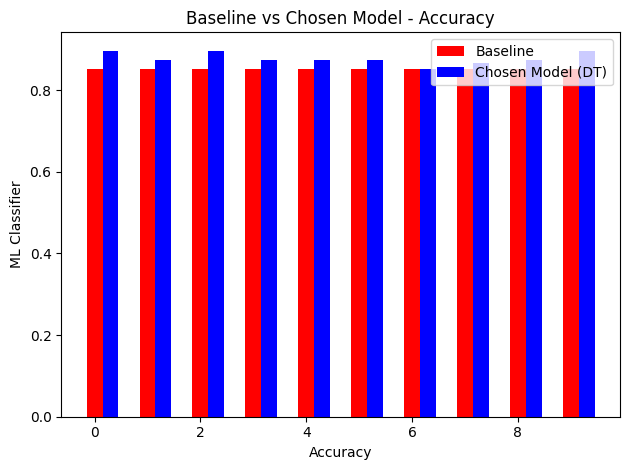

In [30]:
# Visualisation of Accuracy using a Bar Chart
# Reference: https://pythonspot.com/matplotlib-bar-chart/

fig, ax = plt.subplots()
index = np.arange(repeat)

bar_width = 0.3

baseline_plot = plt.bar(index, nb_accuracy_scores, bar_width,
alpha=1,
color='r',
label='Baseline')

dt_plot = plt.bar(index + bar_width, dt_accuracy_scores, bar_width,
alpha=1,
color='b',
label='Chosen Model (DT)')

plt.xlabel('Accuracy')
plt.ylabel('ML Classifier')
plt.title('Baseline vs Chosen Model - Accuracy')

plt.legend()

plt.tight_layout()
plt.show()

## References

Grid Search. https://medium.com/biased-algorithms/grid-search-for-decision-tree-ababbfb89833

Statistical Hypothesis Testing. https://www.maartengrootendorst.com/blog/validate/

Visualisation of Accuracy using a Bar Chart. https://pythonspot.com/matplotlib-bar-chart/
